In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import tanh
from IPython.display import clear_output
from sklearn import preprocessing
from sklearn.utils import shuffle

In [2]:
from MLP import *

In [3]:
f_target = lambda x: x**3
tx = np.sort( (2*np.random.rand(1000)-1)*3 )
ty = np.array( [f_target(x)+(2*np.random.rand()-1) for x in tx ])#.reshape(1,-1)
#ty = preprocessing.normalize(ty,axis=1).reshape(-1)
tx= (tx-np.min(tx))/(np.max(tx)-np.min(tx))
#ty= (ty-np.min(ty))/(np.max(ty)-np.min(ty))

102.65113721688627


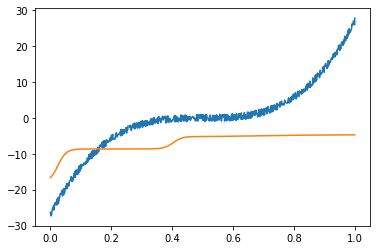

In [4]:
n = MLP(  Nh=[16,10], Nu=1, Ny=1, f=tanh, f_out=ide, w_scale=5 )
plt.plot(tx,ty)
outs = n.supply_sequence(tx)


plt.plot(tx,outs)
print( MSE(outs,ty))

final error: 25.106871399158223


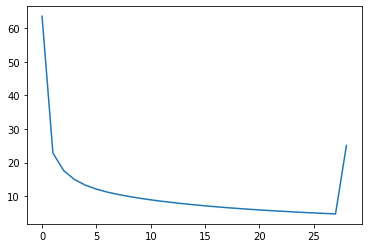

In [5]:
e, _ = n.regression_train(tx, ty, 1e-02,
  a = 0,
  l = 0,
  max_epochs = 1000,
  tresh = 1e-01,
  epoch_f = n.epoch_batch_BP,
  measure_interval = 10 )

plt.plot(e)

11.987706483380109


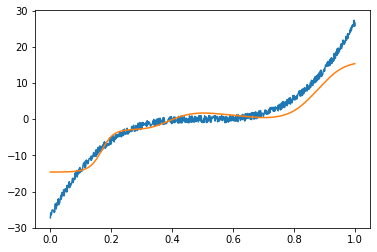

In [6]:
plt.plot(tx,ty)
outs = n.supply_sequence(tx)
plt.plot(tx,outs)
print( MSE(outs,ty))


# Monk test 1

In [ ]:
import pandas as pd
from keras.utils import to_categorical
data = pd.read_csv('monks-1.train',sep=' ',index_col=8)
data = data.drop(columns = data.columns[0])
data = data.to_numpy()

ty = data[:100,0] ; ty = 
tx = data[:100,1:]

vy = data[100:,0] ; vy = vy[vy==0]-1
vx = data[100:,1:]

In [ ]:
n = MLP(  Nh=200, Nl=1, Nu=6, Ny=1, f=tanh, f_out=tanh, w_scale=.5 )
outs = [float(n.predict(u)) for u in tx]
print( MSE(outs,ty))

In [ ]:
max_epochs=5000
tresh=.01
t = [None]*max_epochs
v = [None]*max_epochs

for i in range(max_epochs):
  stx, sty = shuffle(tx, ty)
  n.batch_BP(stx,sty,1e-02, a=1e-09,l=0)
  t[i] = MSE( [float(n.predict(u)) for u in tx] ,ty)
  v[i] = MSE( [float(n.predict(u)) for u in vx] ,vy)
  if i>2 and ( t[i] < tresh or t[i]>t[i-1] ):
    print(t[i]-t[i-1] < 1e-04 , t[i] < tresh)
    break
  print(t[i])
  clear_output(wait=True)

plt.plot(t,'-b')
plt.plot(v,'--b')

In [ ]:
def classify(u):
  return -1 if float( n.predict(u) )<0 else 1

def score(o,d): # ouputs, desired
  return ( o - d == 0).sum()/len(o)*100

outs = [ classify(u) for u in tx]
print('train:',score(outs,ty))

outs = [ classify(u) for u in vx]
print('train:',score(outs,vy))

# Monk test 2


In [ ]:
import pandas as pd
data = pd.read_csv('monks-2.train',sep=' ',index_col=8)
data = data.drop(columns = data.columns[0])
data = data.to_numpy()

ty = data[:100,0] ; ty[ty==0] = ty[ty==0]-1
tx = data[:100,1:]

vy = data[100:,0] ; vy[vy==0] = vy[vy==0]-1
vx = data[100:,1:] 

n = MLP(  Nh=200, Nl=1, Nu=6, Ny=1, f=tanh, f_out=tanh, w_scale=.5 )
outs = [float(n.predict(u)) for u in tx]
print( MSE(outs,ty))

max_epochs=5000
tresh=.01
t = [None]*max_epochs
v = [None]*max_epochs

for i in range(max_epochs):
  stx, sty = shuffle(tx, ty)
  n.batch_BP(stx,sty,1e-02, a=1e-09,l=0)
  t[i] = MSE( [float(n.predict(u)) for u in tx] ,ty)
  v[i] = MSE( [float(n.predict(u)) for u in vx] ,vy)
  if i>2 and ( t[i] < tresh or t[i]>t[i-1] ):
    print(t[i]-t[i-1] < 1e-04 , t[i] < tresh)
    break
  print(t[i])
  clear_output(wait=True)

plt.plot(t,'-b')
plt.plot(v,'--b')

In [ ]:
def classify(u):
  return -1 if float( n.predict(u) )<0 else 1

def score(o,d): # ouputs, desired
  return ( o - d == 0).sum()/len(o)*100

outs = [ classify(u) for u in tx]
print('train:',score(outs,ty))

outs = [ classify(u) for u in vx]
print('train:',score(outs,vy))